<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Combined,-All-data" data-toc-modified-id="Combined,-All-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Combined, All data</a></span></li><li><span><a href="#Preprocessing-and-predictive-modeling" data-toc-modified-id="Preprocessing-and-predictive-modeling-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Preprocessing and predictive modeling</a></span></li></ul></div>

## Combined, All data

In [53]:
import functools
import pdb 
import glob
import copy
import math
import pickle

import numpy as np
import pandas as pd
import scipy as sp
import sklearn

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import missingno  # for visualizing missing data

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, \
    LogisticRegressionCV, SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, \
    precision_recall_curve, average_precision_score, f1_score, \
    roc_curve, auc, roc_auc_score

from sklearn.externals import joblib
from sklearn.utils import resample
from sklearn.utils.fixes import signature

# Set up pandas table display
pd.set_option('display.width', 120)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Set plotting options
sns.set() # Use seaborn defaults for plotting
%matplotlib inline 

# Carry out operations common to all versions of data
# Get all the csv files in the data directory
files = glob.glob('data_raw/*.csv')

# Read those files into pandas
all_data_list = [pd.read_csv(file, header=1, low_memory=False) for file in files]

# Concatenate them into one DataFrame
all_data = pd.concat(all_data_list, ignore_index=True)
# Get rid of the individual DataFrames
del all_data_list 

# Create target variable
all_data['default'] = np.NaN
all_data.loc[all_data.loan_status.str.contains('Fully Paid', na=False), 'default'] = 0 
all_data.loc[(all_data.loan_status.str.contains('Charged Off', na=False)|
             (all_data.loan_status=='Default')), 'default'] = 1

# Set an impossible value to missing
all_data.loc[all_data.dti==-1, 'dti'] = np.nan

# Drop loans with indeterminate status
all_data = all_data.loc[all_data.default.notnull(),:]

# Find columns with 0 or 1 unique values
constant_or_missing = [col for col in all_data.columns 
                           if all_data.loc[:,col] \
                                   .value_counts() \
                                   .shape[0] \
                                <= 1] 

# Delete those columns
all_data = all_data.drop(constant_or_missing + ['loan_status'], axis=1)

# Create hierarchical INDEX with date and ID
all_data['issue_d'] = pd.to_datetime(all_data.loc[:,'issue_d'], format='%b-%Y')
all_data = all_data.set_index(['issue_d', 'id']).sort_index()

# PICKLE data frame
with open('data_processed/all_data_uncleaned.pickle', 'wb') as pickled_file: 
    pickle.dump(all_data, pickled_file) 

In [51]:
# Define function that creates different versions of data 
def make_data(df, v_to_drop=[endogenous, lc, irrelevant, other_to_drop],
              drop_missing ='ideal', transform_time_since=True,
              transform_types=True, normalize_by_income=True,
              transform_skewed_v=True):
    """
    Creates different versions of data to compare performance of predictive
    models on data with different amount of cleaning, data engineering, etc.
    """
    
    # Load original data
    with open('data_processed/all_data_uncleaned.pickle', 'rb') as pickled_file: 
        df = pickle.load(pickled_file) 

    # Drop ENDOGENOUS and IRRELEVANT variables
    # ------------------------------------------
    irrelevant = ['url', 'initial_list_status']
    endogenous = ['out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 
                  'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 
                  'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 
                  'debt_settlement_flag', 'last_fico_range_low', 'last_fico_range_high',
                  'last_credit_pull_d']
    lc = ['int_rate', 'grade', 'sub_grade']
    other_to_drop = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv']
    
    # Concatenate user-specified lists of variables to drop, if more than 
    # one list is supplied
    if len(v_to_drop) > 1:
        v_to_drop = functools.reduce(lambda x, y: x + y, v_to_drop)
    # Drop variables
    df = df.drop(endogenous + lc + irrelevant + other_to_drop, axis='columns')
    # Inform user about which variables were dropped
    print('Endogenous and irrelevant variables dropped: {}'
              .format(v_to_drop))

    
    ## MISSING VALUES
    # ---------------
    # Calculate the proportion of missing values for each variable
    missing = (df.isnull().sum()/df.shape[0]) \
                    .sort_values(ascending=False)
    variables_to_inspect = ['mths_since_last_record', 'mths_since_recent_bc_dlq',
                            'mths_since_last_major_derog', 'mths_since_recent_revol_delinq',
                            'mths_since_last_delinq']
    # If specified, drop missing values as we found to be optimal in the data cleaning notebook 
    if drop_missing == 'ideal':
        variables_to_plot_1 = missing[missing>.75].index # Select columns
        # Create a list of variables to delete, and add all the plotted variables except the last two
        variables_to_drop = list(variables_to_plot_1[:-2])
        variables_to_plot_2 = missing[(missing <= .75) & (missing > .3)].index # Select columns   
        # Add variables to list of variables to delete
        variables_to_drop.extend([v for v in variables_to_plot_2 if v not in variables_to_inspect])
        variables_to_plot_3 = missing[(missing <= .3) & (missing > .005)].index # Select columns
        # Drop variables with too many missing values
        df = df.drop(variables_to_drop, axis='columns')
        # Inform user
        print('Dropping variables as determined to be optimal in the data cleaning notebook')
    
    # If the user-specified specified do not drop any variables, continue
    
    elif (drop_missing is None): 
        print('No variables were dropped due to missing values')
    
    # If specified, drop columns based on proportion of missing values
    else:
        # Get variables whose proportion of missing values exceeds threshold
        variables_to_drop = missing.loc[missing > drop_missing].index
        # Drop them
        df = df.drop(variables_to_drop, axis='columns')
        # Inform user about which variables were dropped
        print('Dropping variables with more than {}% missing values:\n{}' 
                .format(drop_missing * 100, variables_to_drop))


    # Transform "TIME-SINCE" variables
    # -------------------------------
    if transform_time_since: 
        # List to store transformed variables
        new_variables = []
        # Create a list with corresponding counts for each variables
        event_counts = ['pub_rec', None, None, None, 'delinq_2yrs']

        # Perform transformations
        for v, count in zip(variables_to_inspect, event_counts):
            # Get the variable and add 1
            v_transf = df.loc[:, v] + 1
            # Perform power transformation
            v_transf = v_transf ** -0.5
            # pdb.set_trace()
            # Set values to zero where event did not occur
            if count is not None: # If we have a count variable:
                # Get boolean mask where event did not occur
                zero_count = df.loc[:, count]==0
                # Set values to zero 
                v_transf.loc[zero_count] = 0
            else: # Where we don't h–ave event count, set all missings to zero
                v_transf = v_transf.fillna(0)

            # Store transformed variable
            new_variables.append(v_transf)

        # Concatenate transformd variables into data frame
        new_df = pd.concat(new_variables, axis='columns')
        ['inv_sqrt_1p_' + v for v in variables_to_inspect]
        # Add variable names
        new_df.columns = ['inv_sqrt_1p_' + v for v in variables_to_inspect]
        # Print proportion of non-missing observations
        # Add variables to our main data frame
        df = pd.concat([df, new_df], axis='columns')
        # Delete temporary data frame
        del new_df

        # Drop original variables
        df = df.drop(variables_to_inspect, axis='columns')
        
        # Inform user
        print('Transformed "time-since" variable')
        

    
    # Making sure variables are of the right TYPE
    # -------------------------------------------
    if transform_types:
        integers = [variable for variable in df.dtypes[df.dtypes==float].index
                        if df.loc[:, variable].apply(float.is_integer).all()]
        df[integers] = df.loc[:, integers].astype(int)

        # Convert objects to strings
        for variable in ['revol_util']:
            df[variable] = pd.to_numeric(df.loc[:, variable].str.replace('%', ''), errors='coerce')

        df['term_5y'] = np.nan
        df.loc[df.term.str.contains('60 months'), 'term_5y'] = 1
        df.loc[df.term.str.contains('36 months'), 'term_5y'] = 0


        df['earliest_cr_line'] = pd.to_datetime(df.loc[:, 'earliest_cr_line'], format='%b-%Y')

        # Create new variables  with time difference
        df['earliest_cr_line_days'] = \
            (df.reset_index(level='issue_d').issue_d.values
            - df.earliest_cr_line).dt.days

        # Mark original variables for deletion
        variables_to_drop_3 = 'earliest_cr_line'
        # Delete Variables
        df = df.drop(variables_to_drop_3, axis='columns')
        # Inform user
        print('Transformed types')
    

    # NORMALIZE monetary quantities BY INCOME
    # ---------------------------------------
    if normalize_by_income:
        df.assign(
            revol_bal_to_inc = 
                df.revol_bal / df.annual_inc,
            installment_to_inc = 
                (12*df.installment) / df.annual_inc,
            tot_coll_amt_to_inc = 
                df.tot_coll_amt / df.annual_inc,
            tot_cur_bal_to_inc = 
                df.tot_cur_bal / df.annual_inc,
            total_bal_ex_mort_to_inc = 
                df.total_bal_ex_mort / df.annual_inc)

        # Delete original variables, where applicable
        variables_to_drop_2 = \
            ['revol_bal', 'installment', 
             'tot_cur_bal', 'total_bal_ex_mort']
        df = df.drop(variables_to_drop_2, axis='columns')
        # Inform user
        print('Normalized monetary quantities by income')
        

    # If specified, transform SKEWED variables
    # ----------------------------------------

    if transform_skewed_v:
        def mode_at_extremum(df):
            """
            Looks for variables where the mode occurs at the minimum or maximum.

            This is of interest because of censoring: Many variables have a natural
            minimum or maximum, e.g. 0 or 100%, respectively. 

            Parameters
            ----------
            df: pd.DataFrame
                Data frame whose variables to check .

            Returns
            -------
            tuple containing two lists
                First list contains names of variables whose mode occurs at the minimum.
                Second list contains names of variables whose mode occurs at the maximum.
            """

            # Get mode(s) for each variable in the data frame
            modes = df.mode()

            # Get minimum and maximum for each variable in the data frame
            minimum = pd.DataFrame(df.min())
            maximum = pd.DataFrame(df.max())

            # Loop over variables and save names of variables were mode occurs at an
            # extremum.
            mode_at_min = []  
            mode_at_max = []
            for variable in df:
                # Drop missing values from mode and try converting it to scalar
                try:
                    mode_ = np.asscalar(modes.loc[modes[variable].notnull(), variable])
                # If a variable contains multiple modes, we are not interested in it
                except ValueError:
                    print('{} contains multiple modes and will thus be ignored.'.format(variable))

                else:
                    # Convert minimum and maximum to scalars
                    min_ = np.asscalar(minimum.loc[variable])
                    max_ = np.asscalar(maximum.loc[variable])

                    # Test whether minimum or maximum occurs at the mode
                    if (mode_ == min_):
                        mode_at_min.append(variable)
                    elif (mode_ == max_):
                        mode_at_max.append(variable)

            return(mode_at_min, mode_at_max)

        numerics = all_data.select_dtypes(include=[np.number]).columns.tolist()
        mode_at_min, mode_at_max = mode_at_extremum(all_data.loc[:, numerics])

        

        def find_mixtures(df, variables, n_unique_threshold=10,
                          proportion_threshold=0.01, ratio_threshold=5, 
                          verbose=False):
            """
            Identify variables for which we should include a dummy for overly frequent unique values.

            For each variable in a DataFrame, identify unique values that occur so often that
            this variable is best modeled as being generated by a mixture process. I 
            operationalize such a value as occurring at least 10 times as often as would be 
            expected if all unique values occurred with the same frequency. For example, if
            the variable has 15 unique values, 

            A mixture process looks as follows:
            First, a Bernoulli variable determines if the variable takes on a particular discrete 
            value. This may be repeated for other particular discrete values.  If this is not 
            the case, the value is drawn from a different process such as a normal or poisson
            distribution. 

            Parameters
            ----------
            df: pd.DataFrame
                Data frame containing the variables to analyze.
            variables: list
                Variables, located in df, which to check. Usually these will be variables that
                have their mode at their minimum or maximum (e.g., the output from
                mode_at_extremum() ).
            n_unique_threshold: int
                The minimum number of unique values of variable must have in order to be 
                considered.
            proportion_threshold: numeric, optional
                The minimum proportion of observations in the samples that must have the most
                frequent value in order for the variable to be considered. This can be used to
                filter out variables where no value occurs frequently. Default: 1%.
            ratio_threshold: numeric, optional
                Threshold to use for the ratio of the most frequent to the second-most frequent 
                count. If it is exceeded, the variable will be treated as a deriving from a 
                mixture distribution. Default: 5
            verbose: bool
                If true, print out the ratio of the most frequent to the second-most frequent
                count for each variable. Default: False

            Returns
            -------
            list
                Names of variables that seem to derive from a mixture distribution.
            """

            mixtures = []
            # Go through all variables and look for mixtures
            for variable in variables:
                # Count unique values
                valuecounts = df.loc[:, variable].value_counts()

                # Skip variables whose number of unique values does not exceed the
                # supplied threshold
                if len(valuecounts) < n_unique_threshold:
                    continue

                # Skip variables where no single value occurs frequently 
                if valuecounts.iloc[0] < proportion_threshold * len(df):
                    continue

                # Compute ratio of occurrence of most-frequent to second-most frequent value
                ratio = valuecounts.iloc[0] / valuecounts.iloc[1]

                # Print ratio if requested
                if verbose==True:
                    print(variable, ': ', ratio)

                # If ratio is greater than the threshold, save variable name
                if ratio > ratio_threshold:
                    mixtures.append(variable)

            return(mixtures)

        def add_mixture_dummies(df, mixture_min, mixture_max):
            # Initialize dictionary to store dummy variables
            mixture_dummies = {}
            # Create dummies for variables with mode at maximum
            for variable in mixture_max:
                dummy_name = 'max_' + variable
                mixture_dummies[dummy_name] = df.loc[:, variable] == \
                                              df.loc[:, variable].max()

            # Create dummies for variables with mode at minimum
            for variable in mixture_min:
                dummy_name = 'min_' + variable
                mixture_dummies[dummy_name] = df.loc[:, variable] == \
                                              df.loc[:, variable].min()

            # Create data frame with all dummies
            mixture_dummies = pd.DataFrame(mixture_dummies)
            # pdb.set_trace ()
            # Add dummies to original data
            df = pd.concat([df, mixture_dummies], axis='columns')

            return(df)

        def find_mixtures_add_dummies(df, dry_run=True, **kwargs):
            """
            Identify variables for which we should include a dummy for overly frequent 
            unique values. Print variable names or go ahead and add dummies.

            Identify numeric variables where we should add a dummy variable for the mode to
            model the extreme skewness that results from mixture processes such as
            zero-inflation. 

            For each numeric variable in a DataFrame, identify unique values that are 
            located at the minimum or maximum, and that occur so often that this variable is
            best modeled as being generated by a mixture process. The decision rule is
            based on the ratio of the most frequent count to the second-most frequent
            count. By default, this threshold is set to 5.

            The subset of mixture processes we are interested in here look as follows:
            First, a raw from a Bernoulli distribution decides if the variable takes on
            a particular discrete value (often 0 for counts or 100% for proportions). 
            If this is not the case, the variable's value is drawn from a different
            distribution such as a normal or poisson distribution. For simplicity, 
            this subtype of mixture process will simply be referred to as a mixture 
            process, since there is no more exact term.

            Parameters
            ----------
            df: pd.DataFrame
                Data frame to inspect and modify.
            dry_run: bool, optional
                Whether to simply print for which variables would be added, or whether
                to actually add those dummies to the input data frame. Default: only
                print variable names.
            **kwargs
                Additional arguments to change the defaults of find_mixture():
                n_unique_threshold, ratio_threshold, proportion_threshold, verbose.
            """

            # Consider only variables that are numeric
            numerics = df.select_dtypes(include=[np.number]).columns.tolist()

            # First find variables where mode occurs at minimum or maximum
            mode_at_min, mode_at_max = \
                mode_at_extremum(df.loc[:, numerics])

            # Find which of those variables have an inflated number of 
            # minimum or maximum values
            mixtures_at_min = find_mixtures(df, mode_at_min, **kwargs)
            mixtures_at_max = find_mixtures(df, mode_at_max, **kwargs)


            # By default, only print for which variables a dummy will 
            # be added
            if dry_run == True:
                print('For the following variables, a dummy will be '
                      'added for the MINIMUM:\n{}\n\n'
                      'For the following variables, a dummy will be '
                      'added for the MAXIMUM:\n{}' \
                         .format(mixtures_at_min, mixtures_at_max))

            # If specified, add dummies to original data and also return the
            # names of variables for which a dummy was added
            else: 
                return(add_mixture_dummies(df, mixtures_at_min, mixtures_at_max),
                       mixtures_at_min, mixtures_at_max)


        # Print names of variables for which dummies will be added
        find_mixtures_add_dummies(df, proportion_threshold=0.001) 

        # Add dummies and save lists of variables for which we created dummies
        df, min_dummies, max_dummies = find_mixtures_add_dummies(df, dry_run=False, proportion_threshold=0.001)
        df.columns

        def skewness(data, ignore_min=[], ignore_max=[], 
                     verbose=True, n_threshold=5):
            """
            Returns the skewness of each variable in a Series or DataFrame.

            Skewness is operationalized as follows: 
            log((Upper Quartile - Median)/(Median - Lower Quartile)
            If the median falls on the same value as either the upper or lower quartile, the 
            resulting zero is replaced by a very small number in order to avoid taking the 
            log of zero or dividing by zero, respectively. If all three quartiles fall on 
            the same value, no skewness score is produced because our measure is not
            appropriate for such extremely skewed cases. 

            Parameters
            ----------
            data : Series or DataFrame
                Variable to transform.
            n_threshold : int
                Minimum number of unique values to compute skewness
            verbose : bool
                Whether to inform users for which variables the minimum or maximum was 
                discarded, and for which variables the skewness score is likely unreliable
                due to a low number of unique values.  This should only be turned off if
                those problematic variables have been removed beforehand. Default: True

            Returns
            -------


            If input is of type pd.Series:
                float
                    skewness
            """

            # Inform the user for which variable the minimum or maximum value was ignored
            if verbose == True:
                if len(ignore_min) > 0:
                    print('For the following variables the MINIMUM value was discarded when '
                          'computing the skewness:\n',
                          ignore_min)
                if len(ignore_max) > 0:
                    print('\nFor the following variables the MAXIMUM value was discarded when '
                          'computing the skewness:\n',
                          ignore_max)

            # Make a copy of the input data to operate on
            x = copy.copy(data)

            # Compute number of unique values for each variable
            if verbose == True:
                n_unique = x.nunique()

            # Start by trying to treat the input as a SERIES:
            try:
                # First check whether we need to remove the mode. If so, set to missing
                if x.name in ignore_min:
                    x.loc[x==x.min()] = np.nan
                elif x.name in ignore_max:
                    x.loc[x==x.max()] = np.nan

                # If specified, make sure that there are enough unique values
                if (verbose == True) and (n_unique < n_threshold):
                    print('\n The score for {} is unreliable because it only has {} '
                          'unique values.'
                              .format(x.name, n_unique))

                # Compute quartiles 
                quartiles = x.quantile(q=[.25, .5, .75])          
                upper_width = quartiles[.75] - quartiles[.5]
                lower_width = quartiles[.5] - quartiles[.25]

                # If the three quartiles do NOT fall on the same value, calculate skewness
                if (upper_width != 0) or (lower_width != 0):
                    # If only the lower and middle quartile fall onto the same value, set 
                    # their difference to a very small number to avoid introducing missing 
                    # values due to division by zero.
                    if lower_width == 0:
                        lower_width = .000001
                        # Do the same for the difference between upper quartile and median, 
                        # since a zero here would prevent us from taking the log later.
                    elif upper_width == 0:
                        upper_width = .000001
                    else: # Is there a better way of putting this?
                        pass

                    # Calculate skewness score
                    skewness = np.log(upper_width / lower_width)
                    # If skewness cannot be computed (for reasons other than all three 
                    # variables falling onto the same value, which is addressed below),
                    # a variable. 
                    if not np.isnan(skewness):
                        v_problem = [] # Make it a list for consistency with DataFrames
                    else:
                        v_problem = [x.name]  

                # If all three quartiles fall onto the same value, set skewness to missing
                else:
                    skewness = np.nan        
                    v_problem = []


            # If treating the input data as Series doesn't work, treat it as DATAFRAME
            except AttributeError:   # Because DataFrame doesn't have name attribute
                # Remove min or max from variables where we included a dummy for it
                for variable in x:
                    if variable in ignore_min:
                        x.loc[x[variable] == x[variable].min(), variable] = np.nan
                    elif variable in ignore_max:
                        x.loc[x[variable] == x[variable].max(), variable] = np.nan


                # The following code applies to both SERIES and DATAFRAMEs again:
                # Inform user about variables for which skewness is unreliable due to a
                # small number of unique values:
                if verbose ==True:
                    low_n = n_unique < n_threshold
                    if low_n.any():
                        print('\nThe skewness score for the following variables is unreliable'
                              ' because they do not have enough unique values:\n',
                              n_unique[low_n])

                # Compute quartiles and distance between them
                quartiles = x.quantile(q=[.25, .5, .75])          
                upper_width = quartiles.apply(lambda col: col[.75] - col[.5])
                lower_width = quartiles.apply(lambda col: col[.5] - col[.25])

                # Flag location of variables where all three quartiles fall onto the same value, 
                # so that we can set skewness to missing later (because our measure cannot 
                # deal with such extreme cases.
                extreme_skew = (upper_width == 0) & (lower_width ==0)    
                v_no_skewness = x.columns[extreme_skew].tolist()
                # Inform user for which variables this is the case
                if verbose== True:
                    print('\nThe following variables are too skewed to examine with our measure '
                          '(all three quartiles fall onto the same value):\n',
                          v_no_skewness)

                # If the difference between lower quartile and median is zero, set it to a very small
                # number to avoid introducing missing values due to division by zero.
                lower_width[lower_width == 0] = .000001
                # Do the same for the difference between upper quartile and median, since a zero
                # here would prevent us from taking the log later
                upper_width[upper_width == 0] = .000001

                # Calculate skewness score
                skewness = np.log(upper_width / lower_width)

                # Identify any missing values for skewness (Note that this is BEFORE
                # we manually added missing values for variables where all three quartiles 
                # fall onto the same value)
                if np.isnan(skewness).any():
                    v_problem = skewness[skewness.isnull()].index.tolist()

                    # Inform user about this 
                    if verbose == True:
                        print('Skewness for the following variables could not be '
                              'computed (for reasons other than all three quartiles'
                              ' falling onto the same value):\n'
                                 .format(v_problem))
                else:
                    v_problem = []  

                # Set skewness for variables where all three quartiles fall onto 
                # the same values to missing
                skewness.loc[extreme_skew] = np.nan

            return(skewness, v_problem)

        def log_or_log1p(s):
            """ Returns the log of all strictly positive variables and the log(1+x) 
            of all non-negative variables. Ignores variables with any negative value. 

            Args: s, pd.Series

            """

            # Raise error for log(0) rather than producing NaNs
            with np.errstate(all='raise'):
                # Try taking log
                try:
                    # Exclude missing values manually
                    log = np.log(s[s.notnull()])
                    log.name = 'log_' + s.name

                    return(log)

                except FloatingPointError:
                    pass  # To avoid nesting

                # If this fails, try taking log(1+x)
                try:
                    log1p = np.log1p(s[s.notnull()]) 
                    log1p.name = 'log1p_' + s.name
                    return(log1p)        

                # If this still doesn't work, the variable contains 
                # negative values, so return None.
                except FloatingPointError:
                    return(None)

        def transform_skewness(df, min_dummies, max_dummies,
                               n_threshold_ignore=3, n_threshold_warn=10, 
                               take_log=[], ignore=[], dry_run=True):
            """Applies log-transformation to each variable in a DataFrame where it 
            reduces skewness.

            Only numeric variables with at least 10 unique values are considered (since

            Parameters
            ----------
            df : pd.DataFrame
                Data to diagnose or transform
            min_dummies : list
                Variables for which all minimum values should be ignored when
                computing skewness.
            max_dummies : list
                Variables for which all maximum values should be ignored when
                computing skewness.
            n_threshold_ignore : int
                Specifies the minimum number of unique values a variable must 
                exceed in order to be considered.
            n_threshold_warn : int
                Specifies the minimum number of unique values a variable must
                exceed so that the user is not warned to examine it manually.
            take_log : list, optional
                Variables for which you take the log without examining them first.
                This is particularly useful after already having performed a 
                manual diagnosis during the dry-run. Default: Empty list.
            ignore : list, optional
                Variables to ignore. Default: Empty list.
            dry_run : boolean
                If False, performs the transformations.  If True, prints which
                transformations would be performed, along with some additional 
                information. Default: False.

            Returns
            -------
            If dry_run == False:
                df_new : pd.DataFrame
                    Transformed data
                df_deleted_v: pd.DataFrame
                    Deleted (untransformed) variables

            If dry_run == True:
                None

            """

            # Make sure arguments are of the right type
            if not isinstance(take_log, list):
                raise TypeError('take_log must be of type list.')
            if not isinstance(ignore, list):
                raise TypeError('ignore must be of type list.')

            ## Select only relevant variables
            # Get names of all the numeric features
            v_numeric_all = df.select_dtypes(include=[np.number]).columns.tolist()
            # Disregard variables that user-specified to ignore
            v_numeric = [v for v in v_numeric_all if v not in ignore]
            # Count the number of unique values for each numeric variable
            n_unique = df.loc[:, v_numeric].nunique()
            # Ignore variables with very low counts (and save their names)
            v_very_low_count = n_unique.loc[n_unique <= n_threshold_ignore]

            # Make a list of transform  candidates that excludes variables that are
            # not numeric or have very low counts of unique values
            transform_candidates = [v for v in v_numeric if v not in v_very_low_count]

            # Save variables with moderately low number of unique values, so that
            # we can suggest to examine them manually
            v_low_count = n_unique.loc[(n_unique <= n_threshold_warn) & 
                                       (n_unique > n_threshold_ignore)]


            ##  Try log transformation
            # Calculate skewness before transformation (if we added a dummy for
            # min or max, ignore those values and calculate skew for other values only)
            skew_level, v_problem_level = skewness(df.loc[:, transform_candidates], 
                                                  ignore_min=min_dummies, 
                                                  ignore_max=max_dummies,
                                                  n_threshold=n_threshold_ignore,
                                                  verbose=False)

            # Create list to store transformed variables if they are less skewed
            v_to_transform = []
            # Create a list of the variables to delete because they were transformed
            v_to_delete = []
            # Create list to store variables where transformation failed due to 
            # negative values
            v_negative = []
            # Create list to store variables where transformation failed for 
            # other reasons
            v_trans_failed = []
            # Create a list to store variables where user-specified to take the log
            # either way but it was not possible.
            v_take_log_problem = []
            # Create a list to store variables where a problem occurred computing the
            # skewness (other than the three quartiles falling onto the same value)
            v_problem_log = []
            # Create lists to store variables where skewness couldn't be computed
            # because the three quartiles fall onto the same value
            v_no_skewness_both= []  # Neither could be computed
            v_no_skewness_level = []  # Skewness for level couldn't be computed
            v_no_skewness_log = []  # Skewness for log couldn't be computed

            # Create lists of variables for which to ignore the minimum or 
            # maximum for the log-transformed variables
            min_dummies_log = [prefix + v for v in min_dummies 
                               for prefix in ['log_', 'log1p_']]
            max_dummies_log = [prefix + v for v in max_dummies
                               for prefix in ['log_', 'log1p_']]

            # Loop over all the numeric variables, apply transformations, and determine
            # what minimizes the skewness
            for v in transform_candidates:
                col = df.loc[:, v]  # Extract column 

                # Try taking the log
                log = log_or_log1p(col)         

                # If the user specified to take the log either way, do the following:
                # Save the transformed variable, so we can add it to data
                if v in take_log:
                    v_to_transform.append(log)
                    # Save name of untransformed variable, so we can delete it
                    v_to_delete.append(v)
                    assert len(v_to_transform)==len(v_to_delete) 
                    # Go on to the next variable
                    continue

                # If taking the log was possible, calculate skewness. 
                # (If we added a dummy for min or max, ignore those valuesa
                # and calculates skewness only for the other values)
                if log is not None:
                    # Create updated lists of variables for which to ignore
                    # minimum or maximum
                    skew_log, v_problem = skewness(log, verbose=False, 
                                                   n_threshold=n_threshold_ignore,
                                                   ignore_min=min_dummies_log,
                                                   ignore_max=max_dummies_log)
                    # Add names of variables where a problem occurred to the list
                    v_problem_log.extend(v_problem)

                # If transformation wasn't possible, check if it's due to any 
                # negative values. Then save name of offending variable.
                else:
                    #  Since we're taking log(1+x), the threshold is -1, not 0.              
                    if df.loc[:, v].min() <= -1:    
                        v_negative.append(v)
                    else:
                        v_trans_failed.append(v)
                    # If the user-specified to take the log either way, note
                    # that it wasn't possible
                    if v in take_log:
                        v_take_log_problem.append(v)
                    # Move onto the next variable
                    continue

                # (Execute this block only if log-transformation was successful)    
                # Determine if transformation decreased skew
                # Compute absolute value of skewness
                abs_skew_level = abs(skew_level[v])
                abs_skew_log =abs(skew_log)

                # If log-transformation decreases skew do the following steps:
                # (Remember that if one scalar is NaN, x<y will return False) 
                if abs_skew_level >= abs_skew_log:
                    # Save the transformed variable, so we can add it to data
                    v_to_transform.append(log)
                    # Save name of untransformed variable, so we can delete it
                    v_to_delete.append(v)
                    assert len(v_to_transform)==len(v_to_delete) 

                # If transformation doesn't decrease skewness, proceed to the next variable
                elif abs_skew_level <= abs_skew_log:
                    continue

                # If skewness can't be calculated, save variable name
                elif np.isnan(abs_skew_level) and np.isnan(abs_skew_log):
                    v_no_skewness_both.append(v)
                elif np.isnan(abs_skew_log):
                    v_no_skewness_log.append(v)
                # If we only have a skewness score for the log, keep log not level
                elif np.isnan(abs_skew_level):
                    v_no_skewness_level.append(v)
                    # Save the transformed variable, so we can add it to data
                    v_to_transform.append(log)
                    # Save name of untransformed variable, so we can delete it
                    v_to_delete.append(v) 


            # Print and return results
            # ------------------------
            output_dict = {} # Dictionary with the results to return

            # Inform user about important issues
            output_dict['skewness_problem'] = v_problem_level + v_problem_log
            if (len(v_problem_level) > 0) and (len(v_problem_log) > 0):
                    print('A problem occurred when trying to compute the skewness '
                          'of the following variables (even though their quartiles '
                          'do NOT all fall under the same value):\n{}\n'
                             .format(v_problem_level + v_problem_log))

            output_dict['transformation_failed_other_reasons'] = v_trans_failed
            if len(v_trans_failed) > 0:
                print('The following variables cannot be transformed, even though '
                      'they do NOT contain values less than or equal to -1:\&{}\n'
                          .format(v_trans_failed))


            # Inform user about less important issues (print only if specified)
            # related to the number of unique observations
            output_dict['very_low_unique'] = v_very_low_count
            if (dry_run == True) and (len(v_very_low_count) > 0):
                print('The following variables will be ignored because they contain'
                      ' less or equal than {} unique values:\n{}\n'
                         .format(n_threshold_ignore, v_very_low_count))

            output_dict['low_unique'] = v_low_count
            if (dry_run == True) and (len(v_low_count) > 0):
                print('The following variables contain a low number of unique values. '
                      'It might be best to examine them manually if the applied '
                      'transformation makes sense, or if it is be better to model '
                      'them as categorical: \n', v_low_count, '\n')

            # Issues related to log-transformation
            output_dict['below_negative_1'] = v_negative
            if (dry_run == True) and (len(v_to_delete) > 0):
                print('The following variables cannot be transformed because they '
                      'contain values less than or equal to -1:\n{}\n'
                         .format(v_negative))
            # If the log-transformation failed even though the user-specified that
            # it should be conducted either way, notify the user (even if dry-run
            # is False)
            if (len(v_take_log_problem) > 0):
                print('Even though it was specified to take the log of the following'
                      ' variable either way, it wasn\'t possible:\n {}\n'
                          .format(v_take_log_problem))

            # Issues related to skewness
            output_dict['all_3_quartiles_equal_both'] = v_no_skewness_both
            if (dry_run == True) and (len(v_no_skewness_both) > 0):
                print('The following variables will be ignored because skewness couldn\'t'
                      ' be computed (all three quartiles fall onto the same '
                      'value) for both the level and the log:\n{}\n'
                         .format(v_no_skewness_both))

            output_dict['all_3_quartiles_equal_log_only'] = v_no_skewness_log
            if (dry_run == True) and (len(v_no_skewness_log) > 0):
                print('The following variables will be left untransformed because '
                      'skewness could only be calculated for the level, but not the '
                      'log:\n{}\n'
                         .format(v_no_skewness_log))

            output_dict['all_3_quartiles_equal_level_only'] = v_no_skewness_level
            if (dry_run == True) and (len(v_no_skewness_level) > 0):
                print('The following variables will be transformed, but note that '
                      'skewness could only be calculated for the log:\n{}\n'
                         .format(v_no_skewness_level))

            # Print how many variables will be transformed
            print('Number of variables to be transformed: {}\n'
                  'Number of variables left unchanged: {}\n'
                      .format(len(v_to_delete), 
                          len(transform_candidates) - len(v_to_delete)))

            # If specified, print which variables will be transformed
            if dry_run == True:
                print('The following variables will be transformed:\n{}\n\n'
                      'The following variables will NOT be transformed:\n{}'
                        .format(v_to_delete,
                                [v for v in transform_candidates 
                                 if v not in v_to_delete]))

            # If dry-run is True, only return dictionary with results
            if dry_run == True:
                return(output_dict)


            ## Otherwise, modify original data
            else:
                # Remove level of variables where log decreased skew, and save them to a 
                # separate data frame (in case we need them later)
                df_deleted_v = df.loc[:, v_to_delete]
                df_new = df.drop(v_to_delete, axis='columns')

                # Create a new data frame with the logs of the deleted variables
                df_logs = pd.concat(v_to_transform, axis='columns')
                # Add these transformed variables to our new data frame
                df_new = pd.concat([df_new, df_logs], axis='columns')

                return(df_new, df_deleted_v, output_dict)

        # Ignore variables which we already transformed otherwise above 
        v_to_ignore = ['inv_sqrt_1p_' + v for v in variables_to_inspect]

        # Get diagnostics about what transformations will be performed
        log_diagnostics_before = transform_skewness(df, 
                                                    min_dummies=min_dummies, 
                                                    max_dummies=max_dummies,
                                                    ignore=v_to_ignore)

        # Carry out the transformations
        df, df_levels_old, log_diagnostics_trans = \
            transform_skewness(df, min_dummies=min_dummies, max_dummies=max_dummies, 
                               dry_run=False, ignore=v_to_ignore,
                               take_log=log_diagnostics_before['all_3_quartiles_equal_both'])

In [52]:
# Create data sets with different kinds of columns dropped
data_1 = {}
data_1['all'] = make_data(all_data, v_to_drop=[])
data_1['w/o irrelevant'] = make_data(all_data, v_to_drop=[irrelevant])
data_1['w/o irrelevant & endog.'] = make_data(all_data, v_to_drop=[irrelevant, endogenous])
data_1['w/o irrelevant & endog. & LC'] = make_data(all_data, 
                                                   v_to_drop=[irrelevant, endogenous, lc])
data_1['w/o irrelevant & endog. & LC & others'] = make_data(all_data)

Endogenous and irrelevant variables dropped: []
Dropping variables as determined to be optimal in the data cleaning notebook
Transformed "time-since" variable
Transformed types
Normalized monetary quantities by income
hardship_amount contains multiple modes and will thus be ignored.
orig_projected_additional_accrued_interest contains multiple modes and will thus be ignored.
For the following variables, a dummy will be added for the MINIMUM:
['delinq_2yrs', 'pub_rec', 'collections_12_mths_ex_med', 'tot_coll_amt', 'bc_open_to_buy', 'chargeoff_within_12_mths', 'delinq_amnt', 'num_accts_ever_120_pd', 'num_tl_90g_dpd_24m', 'pub_rec_bankruptcies', 'tax_liens', 'total_il_high_credit_limit', 'inv_sqrt_1p_mths_since_last_record', 'inv_sqrt_1p_mths_since_recent_bc_dlq', 'inv_sqrt_1p_mths_since_last_major_derog', 'inv_sqrt_1p_mths_since_recent_revol_delinq', 'inv_sqrt_1p_mths_since_last_delinq']

For the following variables, a dummy will be added for the MAXIMUM:
['pct_tl_nvr_dlq']
The following 

Number of variables to be transformed: 34
Number of variables left unchanged: 15

Endogenous and irrelevant variables dropped: ['url', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'debt_settlement_flag', 'last_fico_range_low', 'last_fico_range_high', 'last_credit_pull_d', 'int_rate', 'grade', 'sub_grade']
Dropping variables as determined to be optimal in the data cleaning notebook
Transformed "time-since" variable
Transformed types
Normalized monetary quantities by income
hardship_amount contains multiple modes and will thus be ignored.
orig_projected_additional_accrued_interest contains multiple modes and will thus be ignored.
For the following variables, a dummy will be added for the MINIMUM:
['delinq_2yrs', 'pub_rec', 'collections_12_mths_ex_med', 'tot_coll_amt', 'bc_open_to_buy', 'chargeoff_within_12_mths', '

In [54]:
# PICKLE dictionary of data frames
with open('data_processed/data_1.pickle', 'wb') as pickled_file: 
    pickle.dump(data_1, pickled_file) 

## Preprocessing and predictive modeling

emp_title     322952
title          62405
zip_code         938
addr_state        51
dtype: int64
Predicted   True  False
Actual                 
True       0.009  0.196
False      0.009  0.787


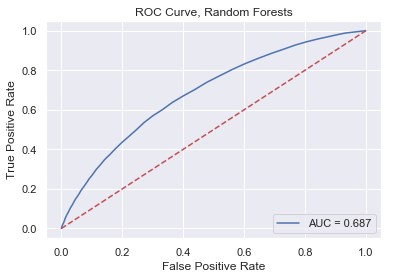

In [9]:
# Preprocessing
# Find categorical variables with more than 50 unique values and drop them
unique_values_cat = all_data.select_dtypes(include='object') \
                        .nunique() \
                        .sort_values(ascending=False) 
print(unique_values_cat[unique_values_cat > 50])
# Drop variables
all_data = all_data.drop(unique_values_cat[unique_values_cat > 50].index,
    axis='columns')


# Train-test split (for now only select 1% for training)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = \
    train_test_split(all_data.drop('default', axis='columns'),
                     all_data.default,
                     #train_size=0.8,
                     train_size=50000, test_size=50000,
                     random_state=1,
                     shuffle=True, stratify=all_data.default) 

# Imputation and standardization for numeric features
numeric_features = X_train.select_dtypes(include=[np.number]).columns
numeric_transformer = Pipeline(steps =[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())]) 

# Imputation and one-hot encoding for categorical features
categorical_features = X_train.select_dtypes(include=[object]).columns
categorical_transformer = Pipeline(steps =[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combining preprocessing for both kinds of features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)],
    remainder='passthrough', n_jobs=1)

# Apply preprocessing
X_train_p = preprocessor.fit_transform(X_train)
X_test_p = preprocessor.transform(X_test)

#####Random Forests
rf = RandomForestClassifier(n_estimators=100, 
        oob_score=True, n_jobs=3, random_state=1,
        class_weight='balanced_subsample')
rf.fit(X_train_p, y_train)


def plot_confusion_matrix(y_test, y_pred, digits=3):
    cf = pd.DataFrame(confusion_matrix(y_test, y_pred,
                                      labels=[1,0]),
                      columns=['True', 'False'])
    cf.index=['True', 'False']
    cf.columns.name = 'Predicted'
    cf.index.name = 'Actual'
    print(round(cf / len(y_test), digits))    

# Plot confusion matrix for random forests
y_pred_rf = rf.predict(X_test_p)
plot_confusion_matrix(y_test, y_pred_rf)


def plot_roc(y_test, y_pred, model_name=None):
    false_positive_rate, true_positive_rate, thresholds = \
        roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, 'b',
             label='AUC = {0:.3f}'.format(roc_auc))
    plt.legend(loc='lower right')
    plt.plot([0, 1],[0, 1], 'r--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    title='ROC Curve'
    # Add custom title, if specified
    if model_name is not None:
        title = ', '.join([title, model_name])
    plt.title(title)
    plt.show();
    
# Plot ROC curve for random forests
y_pred_proba_rf = rf.predict_proba(X_test_p)[:, 1]
plot_roc(y_test, y_pred_proba_rf, 'Random Forests')

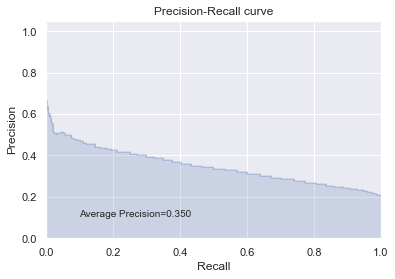

In [10]:
def plot_precision_recall(y_test, y_pred):
    """Plots precision-recall curve."""

    average_precision = average_precision_score(y_test, y_pred)
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    # pdb.set_trace()
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.figtext(0.2, 0.2, 'Average Precision={0:0.3f}' \
                                    .format(average_precision))
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve')
    plt.show();

# Plot precision recall curve for random forests classifier
plot_precision_recall(y_test, y_pred_proba_rf)

In [ ]:
# Get a list of feature names
cat_names = preprocessor.named_transformers_['cat'] \
                .named_steps['onehot'].get_feature_names()
feature_names = list(numeric_features) + list(cat_names)
# Compute feature importance and sort
feature_importances = pd.Series(
                            rf.feature_importances_,
                            index=feature_names) \
                        .sort_values(ascending=False)
print(feature_importances)

Predicted   True  False
Actual                 
True       0.131  0.074
False      0.279  0.516


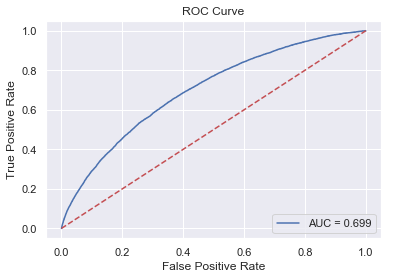

In [11]:
# Logistic regression + Ridge 
lr_ridge = LogisticRegression(
    random_state=1, penalty='l2', class_weight='balanced', 
    C=1E-3, max_iter=100, n_jobs=3, solver='lbfgs')
lr_ridge.fit(X_train_p, y_train) 

# Plot confusion matrix
y_pred_lr = lr_ridge.predict(X_test_p)
plot_confusion_matrix(y_test, y_pred_lr)

# Plot ROC curve
y_pred_proba_lr = lr_ridge.predict_proba(X_test_p)[:, 1]
plot_roc(y_test, y_pred_proba_lr)

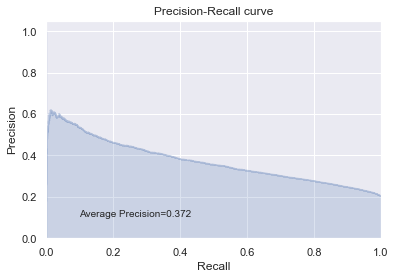

In [14]:
plot_precision_recall(y_test, y_pred_proba_lr)

Predicted   True  False
Actual                 
True       0.124  0.081
False      0.256  0.540


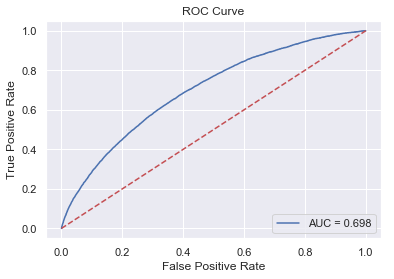

In [12]:
# SVM
svm = SGDClassifier(loss='hinge', penalty='elasticnet', random_state=1,
                   class_weight='balanced', alpha=1E-2,
                    max_iter=100, tol=1E-3)
svm.fit(X_train_p, y_train)

# Plot confusion matrix
y_pred_svm = svm.predict(X_test_p)
plot_confusion_matrix(y_test, y_pred_svm)

# Plot ROC curve
y_pred_proba_svm = svm.decision_function(X_test_p)
plot_roc(y_test, y_pred_proba_svm)

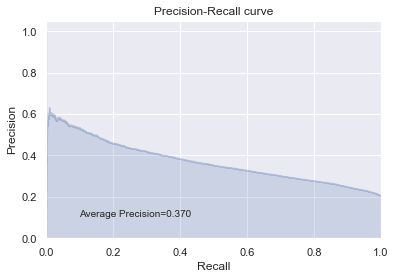

In [16]:
plot_precision_recall(y_test, y_pred_proba_svm)

In [ ]:
print(classification_report(y_test, y_pred_svm))

In [ ]:
variables_to_drop